In [1]:
from tardis import run_tardis
from tardis.visualization import SDECPlotter

from astropy.io import fits
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.size'] = '25'
mpl.rcParams['xtick.labelsize'] = '20'
mpl.rcParams['ytick.labelsize'] = '20'

Iterations:          0/? [00:00<?, ?it/s]

Packets:             0/? [00:00<?, ?it/s]

In [2]:
joj1 = np.loadtxt("../spectroscopy/data/ZTF22aajijjf_20220511_FTN_FLOYDS-N_Global_SN_Project.ascii")
joj2 = np.loadtxt("../spectroscopy/data/ZTF22aajijjf_20220526_SEDM_1.txt")
from scipy.integrate import trapz

flux1 = trapz(joj1[:, 1], joj1[:, 0])
flux2 = trapz(joj2[:, 1], joj2[:, 0])
DL = (114.48 * u.Mpc).cgs.value
luminosity1 = (flux1 * 4 * np.pi * DL**2) / (1 * u.Lsun).cgs.value
luminosity2 = (flux2 * 4 * np.pi * DL**2) / (1 * u.Lsun).cgs.value
z = 0.02736
print('First spec:')
print('wv_min = {:.2f}, wv_max = {:.2f}'.format(joj1[0, 0]/(1+z), joj1[-1, 0]/(1+z)))
print('log L = {:.2f} log Lsun'.format(np.log10(luminosity1)))

print('Second spec:')
print('wv_min = {:.2f}, wv_max = {:.2f}'.format(joj2[0, 0]/(1+z), joj2[-1, 0]/(1+z)))
print('log L = {:.2f} log Lsun'.format(np.log10(luminosity2)))

First spec:
wv_min = 3407.22, wv_max = 9734.75
log L = 8.52 log Lsun
Second spec:
wv_min = 3676.12, wv_max = 8977.67
log L = 9.40 log Lsun


In [3]:
# from tardis.io.atom_data.util import download_atom_data
# download_atom_data('kurucz_cd23_chianti_H_He')

In [4]:
iso_title = np.array('H1  He4 C12  N14  O16  Ne20  Na23  Mg24  Al27  Si28  S32   Ar36  Ca40  Sc45  Ti48  V51   Cr52  Mn55  Fe56  Co59  Ni58  Ni56  Co56  Fe52  Cr48  V48   Mn52'.split())

In [5]:
# from wikipedia
tau_Ni56 = 6.077 / np.log(2)  # Ni-56 --> Co-56
tau_Co56 = 77.233 / np.log(2)  # Co-56 --> Fe-56

tau_Fe52 = 8.275 / 24 / np.log(2)  # Fe-52 --> Mn-52
tau_Mn52 = 21.1 / 60 / 24 / np.log(2)  # Mn-52 --> Cr-52

tau_Cr48 = 21.56 / 24 / np.log(2)  # Cr-48 --> V-48
tau_V48 = 15.9735 / np.log(2)  # V-48 --> Ti-48

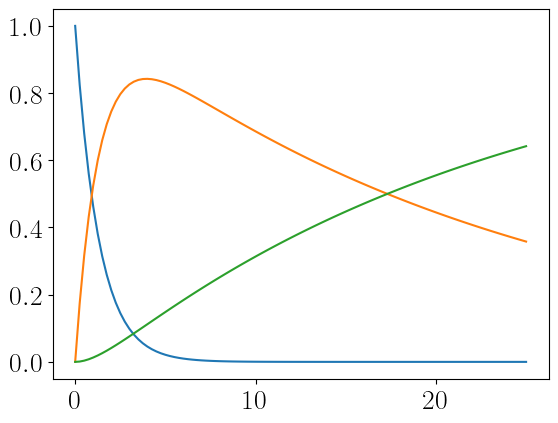

In [6]:
# radioactive decay
from scipy.integrate import odeint

time = np.linspace(0, 25, 101)


def decay_chain(tau1, tau2, n1, n2, n3, time):
    def deriv(A, t, Ab):
        return np.dot(Ab, A)

    Ab = np.array([[-1 / tau1,        0,  0], 
                   [1 / tau1, -1 / tau2,  0], 
                   [0,         1 / tau2,  0]])

    A0 = np.array([n1, n2, n3])

    MA = odeint(deriv, A0, time, args=(Ab,))
    MA = np.where(MA > 0, MA, 0)
    return MA


plt.plot(time, decay_chain(tau_Cr48, tau_V48, 1, 0, 0, time))


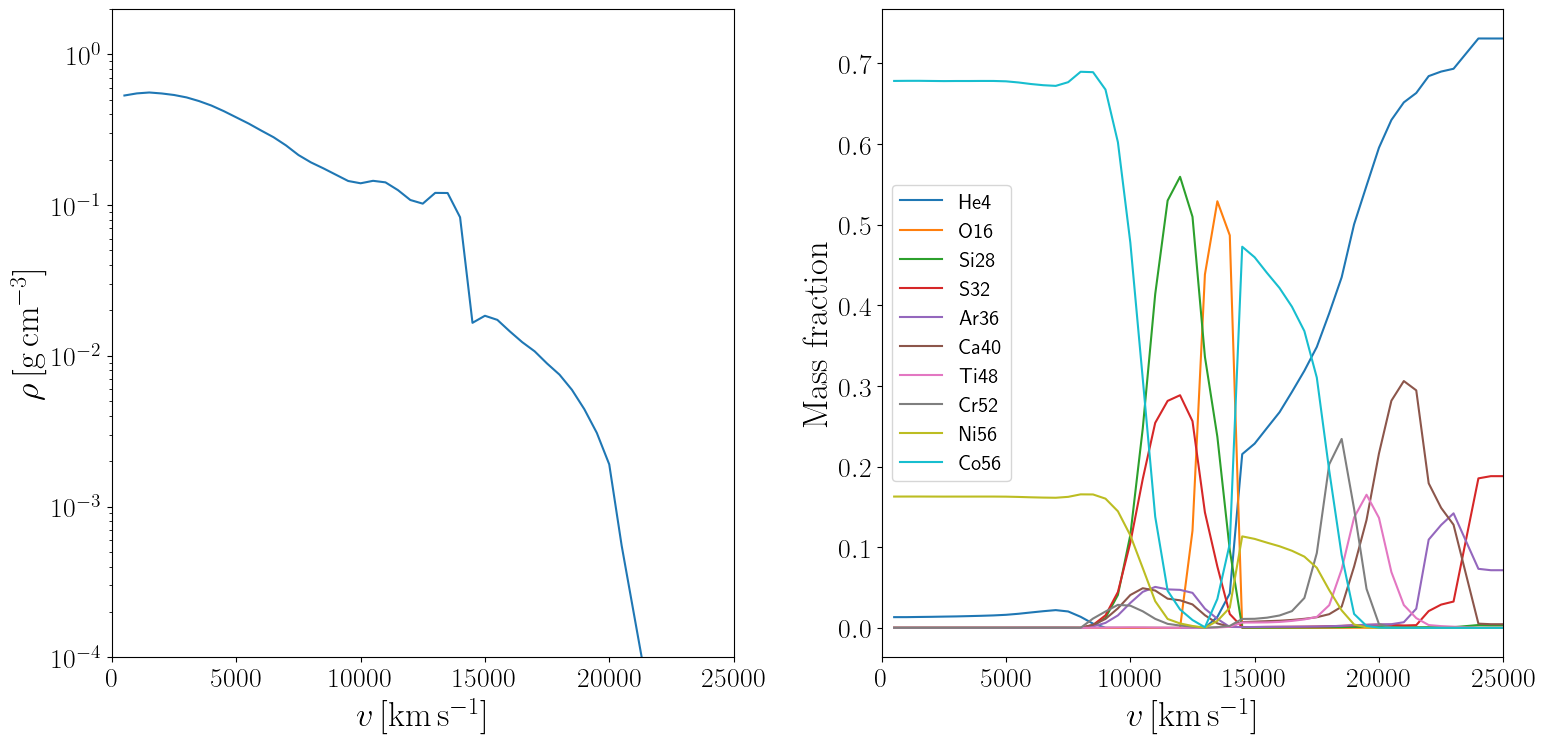

In [7]:
with open("./Shen+2021/d14e5_m100_wedge_mu_00.txt", "r") as f:
    lines = [l for l in f.readlines() if l[0] != "!"]
prof = []
for l in lines[3:]:
    prof.append(np.array(l.split(), dtype=float))
# dat = np.loadtxt('./doubledet_2021_m1003_1_isotopes.dat')
prof = np.array(prof)
prof[:, 0] = prof[:, 0] / 1e5  # cm/s --> km/s
iso_dat = prof[:, 3:].copy()
iso_dat0 = prof[:, 3:].copy()

# Ni56 --> Co56 --> Fe56
idx1 = np.argwhere(iso_title == "Ni56").ravel()[0]
idx2 = np.argwhere(iso_title == "Co56").ravel()[0]
idx3 = np.argwhere(iso_title == "Fe56").ravel()[0]

t_post_exp = 15
for k in range(len(prof)):
    iso_dat[k, idx1], iso_dat[k, idx2], iso_dat[k, idx3] = decay_chain(
        tau_Ni56,
        tau_Co56,
        iso_dat[k, idx1],
        iso_dat[k, idx2],
        iso_dat[k, idx3],
        np.array([0, t_post_exp]),
    )[-1]

# Fe52 --> Mn52 --> Cr52
idx1 = np.argwhere(iso_title == "Fe52").ravel()[0]
idx2 = np.argwhere(iso_title == "Mn52").ravel()[0]
idx3 = np.argwhere(iso_title == "Cr52").ravel()[0]
for k in range(len(prof)):
    iso_dat[k, idx1], iso_dat[k, idx2], iso_dat[k, idx3] = decay_chain(
        tau_Fe52,
        tau_Mn52,
        iso_dat[k, idx1],
        iso_dat[k, idx2],
        iso_dat[k, idx3],
        np.array([0, t_post_exp]),
    )[-1]

# Cr48 --> V48 --> Ti48
idx1 = np.argwhere(iso_title == "Cr48").ravel()[0]
idx2 = np.argwhere(iso_title == "V48").ravel()[0]
idx3 = np.argwhere(iso_title == "Ti48").ravel()[0]
for k in range(len(prof)):
    iso_dat[k, idx1], iso_dat[k, idx2], iso_dat[k, idx3] = decay_chain(
        tau_Cr48,
        tau_V48,
        iso_dat[k, idx1],
        iso_dat[k, idx2],
        iso_dat[k, idx3],
        np.array([0, t_post_exp]),
    )[-1]

idx = np.max(iso_dat, axis=0) > 1e-1
fig, ax = plt.subplots(1, 2, figsize=(16, 8), sharex=True)
ax[0].plot(prof[:, 0], prof[:, 1])
ax[0].set_yscale("log")
ax[1].plot(prof[:, 0], iso_dat[:, idx], label=iso_title[idx])
ax[1].legend(prop={"size": 15})
ax[0].set_ylim(1e-4, 2)
ax[1].set_xlim(0, 25000)
ax[0].set_xlabel(r"$v\,[\mathrm{km}\,\mathrm{s}^{-1}]$")
ax[1].set_xlabel(r"$v\,[\mathrm{km}\,\mathrm{s}^{-1}]$")
ax[0].set_ylabel(r"$\rho\,[\mathrm{g}\,\mathrm{cm}^{-3}]$")
ax[1].set_ylabel(r"$\mathrm{Mass\ fraction}$")
fig.tight_layout()

profile = np.append(prof[:, :2], iso_dat0, axis=1)

In [8]:
def write_CSVY(fname, isotopes, profile, time=0, vmin=8000, vmax=28000, Ti_factor=1):
    lines = '''---
name: csvy_full
model_density_time_0: 0.0012 day
model_isotope_time_0: 0.0012 day
description: Example csvy config file for TARDIS.
tardis_model_config_version: v1.0
datatype:
  fields:
    -  name: velocity
       unit: km/s
       desc: velocities of shell outer bounderies.
    -  name: density
       unit: g/cm^3
       desc: density of shell.'''
    lines = [l + '\n' for l in lines.split('\n')]
    for i in isotopes:
        lines.append('    -  name: {}\n'.format(i))
        lines.append('       desc: fractional {} abundance.\n'.format(i))
    lines.append('---\n')
    lines.append(','.join(np.append('velocity,density', isotopes)) + '\n')

    iso_dat = profile[:, 2:].copy()

    # Ni56 --> Co56 --> Fe56
    idx1 = np.argwhere(isotopes == "Ni56").ravel()[0]
    idx2 = np.argwhere(isotopes == "Co56").ravel()[0]
    idx3 = np.argwhere(isotopes == "Fe56").ravel()[0]
    for k in range(len(prof)):
        iso_dat[k, idx1], iso_dat[k, idx2], iso_dat[k, idx3] = decay_chain(
            tau_Ni56,
            tau_Co56,
            iso_dat[k, idx1],
            iso_dat[k, idx2],
            iso_dat[k, idx3],
            np.array([0, time]),
        )[-1]

    # Fe52 --> Mn52 --> Cr52
    idx1 = np.argwhere(isotopes == "Fe52").ravel()[0]
    idx2 = np.argwhere(isotopes == "Mn52").ravel()[0]
    idx3 = np.argwhere(isotopes == "Cr52").ravel()[0]
    for k in range(len(prof)):
        iso_dat[k, idx1], iso_dat[k, idx2], iso_dat[k, idx3] = decay_chain(
            tau_Fe52,
            tau_Mn52,
            iso_dat[k, idx1],
            iso_dat[k, idx2],
            iso_dat[k, idx3],
            np.array([0, time]),
        )[-1]

    # Cr48 --> V48 --> Ti48
    idx1 = np.argwhere(isotopes == "Cr48").ravel()[0]
    idx2 = np.argwhere(isotopes == "V48").ravel()[0]
    idx3 = np.argwhere(isotopes == "Ti48").ravel()[0]
    for k in range(len(prof)):
        iso_dat[k, idx1], iso_dat[k, idx2], iso_dat[k, idx3] = decay_chain(
            tau_Cr48,
            tau_V48,
            iso_dat[k, idx1],
            iso_dat[k, idx2],
            iso_dat[k, idx3],
            np.array([0, time]),
        )[-1]

    # manually adjust Ti fraction
    idx = np.argwhere(isotopes == "Ti48").ravel()[0]
    iso_dat[:, idx] = iso_dat[:, idx] * Ti_factor

    profile = np.append(profile[:, :2], iso_dat, axis=1)
    
    for d in profile:
        if d[0] < vmin or d[0] > vmax:
            continue
        lines.append(','.join(['{:.5e}'.format(val) for val in d]) + '\n')

    with open(fname, 'w') as f:
        f.writelines(lines)

def write_config(fname, log_L, time, csvy_model):
    hdr = '''# Example YAML configuration for TARDIS
tardis_config_version: v1.0\n'''

    model = '''supernova:
  luminosity_requested: {:.2f} log_lsun
  time_explosion: {:.2f} day
  luminosity_wavelength_start: 3000 angstrom
  luminosity_wavelength_end: 9500 angstrom
atom_data: kurucz_cd23_chianti_H_He.h5

csvy_model: {}\n'''.format(log_L, time, csvy_model)

    simulation = '''plasma:
  disable_electron_scattering: no
  ionization: lte
  excitation: lte
  radiative_rates_type: dilute-blackbody
  line_interaction_type: macroatom

montecarlo:
  seed: 23111963
  no_of_packets: 4.0e+4
  iterations: 20
  nthreads: 1

  last_no_of_packets: 1.e+5
  no_of_virtual_packets: 10

  convergence_strategy:
    type: damped
    damping_constant: 1.0
    threshold: 0.05
    fraction: 0.8
    hold_iterations: 3
    t_inner:
      damping_constant: 0.1

spectrum:
  start: 500 angstrom
  stop: 20000 angstrom
  num: 10000'''
    
    with open(fname, 'w') as f:
        f.writelines(hdr + model + simulation)

In [29]:
with open("./Shen+2021/d14e5_mu_0_spec.txt") as f:
    l = f.readline()
    time = float(l.split("=")[-1])
    l = f.readline()
    log_L = float(l.split("=")[-1])
write_CSVY(
    "./d14e5_mu00_Ti0",
    isotopes=iso_title,
    profile=profile,
    time=time + 3,
    vmin=11000,
    Ti_factor=1,
)
write_config(
    fname="tardis_+2.yml", log_L=log_L - 0.45, time=time + 3, csvy_model="d14e5_mu00_Ti0"
)
sim0 = run_tardis(
    "tardis_+2.yml",
    virtual_packet_logging=True,
    show_convergence_plots=True,
    export_convergence_plots=True,
    log_level="INFO",
)
plotter0 = SDECPlotter.from_simulation(sim0)

[tardis.model.base   ][WARNING]  
	Abundances have not been normalized to 1. - normalizing (base.py:892)
[tardis.plasma.standard_plasmas][INFO   ]  
	
	Reading Atomic Data from kurucz_cd23_chianti_H_He.h5 (standard_plasmas.py:95)
[tardis.io.atom_data.base][INFO   ]  
	Reading Atom Data with: UUID = 6f7b09e887a311e7a06b246e96350010 MD5  = 864f1753714343c41f99cb065710cace  (base.py:249)
[tardis.io.atom_data.base][INFO   ]  
	Non provided Atomic Data: synpp_refs, photoionization_data, yg_data, two_photon_data (base.py:253)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 1 of 20 (base.py:385)


TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:   ', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.476e+42 erg / s
	Luminosity absorbed  = 1.295e+42 erg / s
	Luminosity requested = 4.027e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,6.32e+03,6.78e+03,0.395,0.453
5,6.27e+03,6.46e+03,0.2,0.221
10,6.22e+03,6.02e+03,0.132,0.145
15,6.17e+03,5.16e+03,0.0951,0.147
20,6.12e+03,4.5e+03,0.0722,0.165
25,6.07e+03,4.43e+03,0.0569,0.135
30,6.02e+03,4.37e+03,0.046,0.113


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 6328.637 K
	Expected t_inner for next iteration = 6741.198 K
 (base.py:554)


    'data': [{'type': 'scatter', 'uid': '18417ba9-cc0f-4090-a4ef-336e2c1bb8fc', …

[tardis.simulation.base][INFO   ]  
	
	Starting iteration 2 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.712e+42 erg / s
	Luminosity absorbed  = 1.795e+42 erg / s
	Luminosity requested = 4.027e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,6.78e+03,7.21e+03,0.453,0.478
5,6.46e+03,6.89e+03,0.221,0.251
10,6.02e+03,6.51e+03,0.145,0.175
15,5.16e+03,5.66e+03,0.147,0.175
20,4.5e+03,4.49e+03,0.165,0.209
25,4.43e+03,4.36e+03,0.135,0.175
30,4.37e+03,4.29e+03,0.113,0.146


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 6741.198 K
	Expected t_inner for next iteration = 7101.027 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 3 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 2.264e+42 erg / s
	Luminosity absorbed  = 2.138e+42 erg / s
	Luminosity requested = 4.027e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,7.21e+03,7.66e+03,0.478,0.467
5,6.89e+03,7.36e+03,0.251,0.233
10,6.51e+03,6.99e+03,0.175,0.157
15,5.66e+03,6.17e+03,0.175,0.148
20,4.49e+03,4.73e+03,0.209,0.206
25,4.36e+03,4.6e+03,0.175,0.171
30,4.29e+03,4.53e+03,0.146,0.143


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7101.027 K
	Expected t_inner for next iteration = 7337.934 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 4 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 2.884e+42 erg / s
	Luminosity absorbed  = 2.215e+42 erg / s
	Luminosity requested = 4.027e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,7.66e+03,7.96e+03,0.467,0.445
5,7.36e+03,7.66e+03,0.233,0.208
10,6.99e+03,7.42e+03,0.157,0.133
15,6.17e+03,6.79e+03,0.148,0.118
20,4.73e+03,5.13e+03,0.206,0.176
25,4.6e+03,4.98e+03,0.171,0.149
30,4.53e+03,4.9e+03,0.143,0.125


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7337.934 K
	Expected t_inner for next iteration = 7471.189 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 5 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.475e+42 erg / s
	Luminosity absorbed  = 2.042e+42 erg / s
	Luminosity requested = 4.027e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,7.96e+03,8.16e+03,0.445,0.421
5,7.66e+03,7.65e+03,0.208,0.203
10,7.42e+03,7.22e+03,0.133,0.135
15,6.79e+03,6.65e+03,0.118,0.119
20,5.13e+03,5.5e+03,0.176,0.15
25,4.98e+03,5.35e+03,0.149,0.127
30,4.9e+03,5.27e+03,0.125,0.107


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7471.189 K
	Expected t_inner for next iteration = 7528.392 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 6 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.505e+42 erg / s
	Luminosity absorbed  = 2.129e+42 erg / s
	Luminosity requested = 4.027e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.16e+03,8.34e+03,0.421,0.407
5,7.65e+03,7.83e+03,0.203,0.202
10,7.22e+03,7.27e+03,0.135,0.141
15,6.65e+03,6.51e+03,0.119,0.129
20,5.5e+03,5.44e+03,0.15,0.159
25,5.35e+03,5.32e+03,0.127,0.133
30,5.27e+03,5.24e+03,0.107,0.111


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7528.392 K
	Expected t_inner for next iteration = 7582.521 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 7 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.705e+42 erg / s
	Luminosity absorbed  = 2.076e+42 erg / s
	Luminosity requested = 4.027e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.34e+03,8.4e+03,0.407,0.398
5,7.83e+03,8.17e+03,0.202,0.185
10,7.27e+03,7.77e+03,0.141,0.125
15,6.51e+03,7.03e+03,0.129,0.113
20,5.44e+03,5.56e+03,0.159,0.154
25,5.32e+03,5.43e+03,0.133,0.128
30,5.24e+03,5.35e+03,0.111,0.107


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7582.521 K
	Expected t_inner for next iteration = 7614.843 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 8 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 4.036e+42 erg / s
	Luminosity absorbed  = 1.881e+42 erg / s
	Luminosity requested = 4.027e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.4e+03,8.38e+03,0.398,0.402
5,8.17e+03,8.16e+03,0.185,0.173
10,7.77e+03,7.79e+03,0.125,0.115
15,7.03e+03,6.9e+03,0.113,0.114
20,5.56e+03,5.78e+03,0.154,0.139
25,5.43e+03,5.65e+03,0.128,0.116
30,5.35e+03,5.57e+03,0.107,0.0975


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7614.843 K
	Expected t_inner for next iteration = 7613.983 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 9 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 4.034e+42 erg / s
	Luminosity absorbed  = 1.947e+42 erg / s
	Luminosity requested = 4.027e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 1/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.38e+03,8.42e+03,0.402,0.396
5,8.16e+03,8.12e+03,0.173,0.176
10,7.79e+03,7.62e+03,0.115,0.121
15,6.9e+03,6.8e+03,0.114,0.117
20,5.78e+03,5.77e+03,0.139,0.139
25,5.65e+03,5.65e+03,0.116,0.115
30,5.57e+03,5.57e+03,0.0975,0.0967


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7613.983 K
	Expected t_inner for next iteration = 7613.301 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 10 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.993e+42 erg / s
	Luminosity absorbed  = 1.952e+42 erg / s
	Luminosity requested = 4.027e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 2/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.42e+03,8.43e+03,0.396,0.395
5,8.12e+03,8.25e+03,0.176,0.173
10,7.62e+03,7.77e+03,0.121,0.119
15,6.8e+03,6.99e+03,0.117,0.11
20,5.77e+03,5.74e+03,0.139,0.141
25,5.65e+03,5.62e+03,0.115,0.117
30,5.57e+03,5.54e+03,0.0967,0.098


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7613.301 K
	Expected t_inner for next iteration = 7616.575 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 11 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 4.052e+42 erg / s
	Luminosity absorbed  = 1.897e+42 erg / s
	Luminosity requested = 4.027e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 3/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.43e+03,8.39e+03,0.395,0.398
5,8.25e+03,8.14e+03,0.173,0.175
10,7.77e+03,7.7e+03,0.119,0.118
15,6.99e+03,6.9e+03,0.11,0.114
20,5.74e+03,5.79e+03,0.141,0.139
25,5.62e+03,5.66e+03,0.117,0.115
30,5.54e+03,5.58e+03,0.098,0.0968


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7616.575 K
	Expected t_inner for next iteration = 7614.266 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 12 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 4.018e+42 erg / s
	Luminosity absorbed  = 1.916e+42 erg / s
	Luminosity requested = 4.027e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 4/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.39e+03,8.47e+03,0.398,0.389
5,8.14e+03,8.27e+03,0.175,0.168
10,7.7e+03,7.77e+03,0.118,0.116
15,6.9e+03,6.91e+03,0.114,0.113
20,5.79e+03,5.77e+03,0.139,0.139
25,5.66e+03,5.65e+03,0.115,0.115
30,5.58e+03,5.57e+03,0.0968,0.0964


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7614.266 K
	Expected t_inner for next iteration = 7615.117 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 13 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 4.010e+42 erg / s
	Luminosity absorbed  = 1.894e+42 erg / s
	Luminosity requested = 4.027e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 5/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.47e+03,8.46e+03,0.389,0.389
5,8.27e+03,8.22e+03,0.168,0.17
10,7.77e+03,7.74e+03,0.116,0.117
15,6.91e+03,6.93e+03,0.113,0.113
20,5.77e+03,5.77e+03,0.139,0.139
25,5.65e+03,5.65e+03,0.115,0.116
30,5.57e+03,5.57e+03,0.0964,0.097


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7615.117 K
	Expected t_inner for next iteration = 7616.784 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 14 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 4.026e+42 erg / s
	Luminosity absorbed  = 1.913e+42 erg / s
	Luminosity requested = 4.027e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 6/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.46e+03,8.47e+03,0.389,0.387
5,8.22e+03,8.08e+03,0.17,0.178
10,7.74e+03,7.7e+03,0.117,0.119
15,6.93e+03,6.88e+03,0.113,0.115
20,5.77e+03,5.76e+03,0.139,0.141
25,5.65e+03,5.63e+03,0.116,0.118
30,5.57e+03,5.55e+03,0.097,0.0989


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7616.784 K
	Expected t_inner for next iteration = 7616.871 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 15 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 4.017e+42 erg / s
	Luminosity absorbed  = 1.922e+42 erg / s
	Luminosity requested = 4.027e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 7/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.47e+03,8.43e+03,0.387,0.396
5,8.08e+03,8.12e+03,0.178,0.179
10,7.7e+03,7.76e+03,0.119,0.118
15,6.88e+03,6.88e+03,0.115,0.114
20,5.76e+03,5.76e+03,0.141,0.139
25,5.63e+03,5.64e+03,0.118,0.116
30,5.55e+03,5.56e+03,0.0989,0.0975


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7616.871 K
	Expected t_inner for next iteration = 7617.858 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 16 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.981e+42 erg / s
	Luminosity absorbed  = 1.966e+42 erg / s
	Luminosity requested = 4.027e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 8/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.43e+03,8.48e+03,0.396,0.388
5,8.12e+03,8.15e+03,0.179,0.174
10,7.76e+03,7.66e+03,0.118,0.119
15,6.88e+03,6.9e+03,0.114,0.113
20,5.76e+03,5.76e+03,0.139,0.139
25,5.64e+03,5.64e+03,0.116,0.115
30,5.56e+03,5.56e+03,0.0975,0.0964


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7617.858 K
	Expected t_inner for next iteration = 7622.283 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 17 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 4.041e+42 erg / s
	Luminosity absorbed  = 1.924e+42 erg / s
	Luminosity requested = 4.027e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 9/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.48e+03,8.49e+03,0.388,0.385
5,8.15e+03,8.24e+03,0.174,0.171
10,7.66e+03,7.7e+03,0.119,0.118
15,6.9e+03,6.89e+03,0.113,0.115
20,5.76e+03,5.77e+03,0.139,0.139
25,5.64e+03,5.66e+03,0.115,0.115
30,5.56e+03,5.58e+03,0.0964,0.0967


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7622.283 K
	Expected t_inner for next iteration = 7620.951 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 18 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 4.000e+42 erg / s
	Luminosity absorbed  = 1.932e+42 erg / s
	Luminosity requested = 4.027e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 10/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.49e+03,8.48e+03,0.385,0.388
5,8.24e+03,8.24e+03,0.171,0.168
10,7.7e+03,7.81e+03,0.118,0.114
15,6.89e+03,6.86e+03,0.115,0.115
20,5.77e+03,5.77e+03,0.139,0.139
25,5.66e+03,5.64e+03,0.115,0.116
30,5.58e+03,5.56e+03,0.0967,0.0972


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7620.951 K
	Expected t_inner for next iteration = 7623.586 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 19 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 4.036e+42 erg / s
	Luminosity absorbed  = 1.928e+42 erg / s
	Luminosity requested = 4.027e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 11/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.48e+03,8.45e+03,0.388,0.393
5,8.24e+03,8.32e+03,0.168,0.166
10,7.81e+03,7.83e+03,0.114,0.114
15,6.86e+03,7.02e+03,0.115,0.109
20,5.77e+03,5.78e+03,0.139,0.138
25,5.64e+03,5.67e+03,0.116,0.114
30,5.56e+03,5.58e+03,0.0972,0.096


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7623.586 K
	Expected t_inner for next iteration = 7622.792 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 20 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 4.074e+42 erg / s
	Luminosity absorbed  = 1.877e+42 erg / s
	Luminosity requested = 4.027e+42 erg / s
 (base.py:559)


[tardis.simulation.base][INFO   ]  
	
	Simulation finished in 20 iterations 
	Simulation took 182.81 s
 (base.py:480)


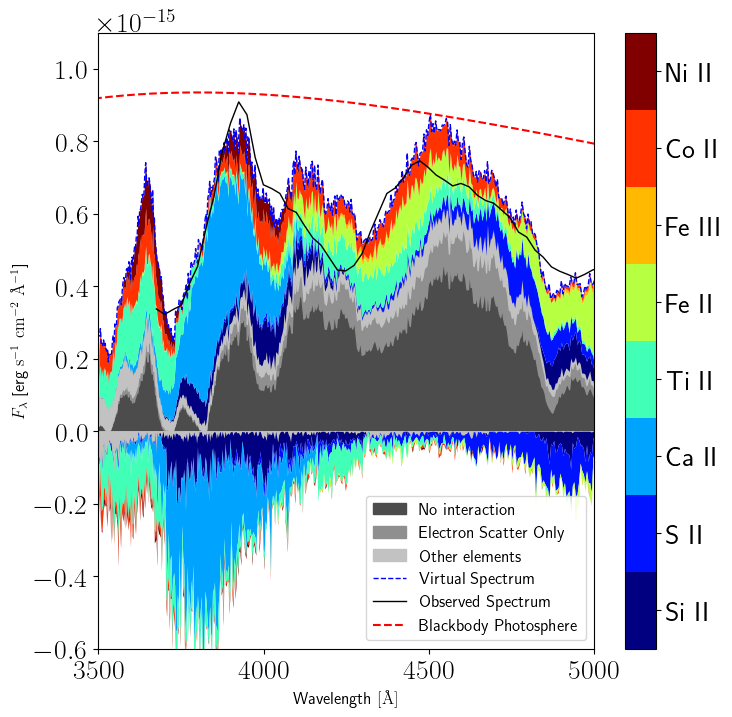

In [30]:
fig, ax = plt.subplots(figsize=(8, 8))
plotter0 = SDECPlotter.from_simulation(sim0)
# 2D SEDONA simulation
syn_dat = np.loadtxt("./Shen+2021/d14e5_mu_0_spec.txt")
plotter0.generate_plot_mpl(
    packet_wvl_range=[3500, 5000] * u.AA,
    # observed_spectrum=(
    #     syn_dat[:, 0] * u.AA,
    #     syn_dat[:, 1] * u.erg / u.cm**2 / u.s / u.AA / 4,
    # ),
    observed_spectrum=(
        joj2[:, 0] / (1 + z) * u.AA,
        joj2[:, 1] * (1 + z) * u.erg / u.cm**2 / u.s / u.AA / 4,
    ),
    distance=114.48 * u.Mpc,
    species_list=["Si II", "S II", "Fe II-III", "Ca II", "Ti II", "Ni II", "Co II"],
    ax=ax
)
ax.legend(loc=4, prop={"size":12})
ax.set_ylim([-.6e-15, 1.1e-15])
ax.set_xlim(3500, 5000)
plt.show()

In [18]:
with open('./Shen+2021/d14e5_mu_0_spec.txt') as f:
    l = f.readline()
    time = float(l.split('=')[-1])
    l = f.readline()
    log_L = float(l.split('=')[-1])
write_CSVY('./d14e5_mu00', isotopes=iso_title, profile=profile, time=time + 5, vmin=10000)
write_config(fname='tardis_+2.yml', log_L=log_L-0.3, time=time, csvy_model='d14e5_mu00')
sim = run_tardis("tardis_+2.yml",
                 virtual_packet_logging=True,
                 show_convergence_plots=True,
                 export_convergence_plots=True,
                 log_level="INFO")
plotter = SDECPlotter.from_simulation(sim)

[tardis.model.base   ][WARNING]  
	Abundances have not been normalized to 1. - normalizing (base.py:892)
[tardis.plasma.standard_plasmas][INFO   ]  
	
	Reading Atomic Data from kurucz_cd23_chianti_H_He.h5 (standard_plasmas.py:95)
[tardis.io.atom_data.base][INFO   ]  
	Reading Atom Data with: UUID = 6f7b09e887a311e7a06b246e96350010 MD5  = 864f1753714343c41f99cb065710cace  (base.py:249)
[tardis.io.atom_data.base][INFO   ]  
	Non provided Atomic Data: synpp_refs, photoionization_data, yg_data, two_photon_data (base.py:253)
[py.warnings         ][WARNING]  
	/Users/chang/miniconda3/envs/tardis/lib/python3.8/site-packages/tardis/plasma/properties/radiative_properties.py:93: RuntimeWarning:

invalid value encountered in true_divide

 (warnings.py:109)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 1 of 40 (base.py:385)


TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:   ', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.870e+42 erg / s
	Luminosity absorbed  = 2.137e+42 erg / s
	Luminosity requested = 5.689e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,7.85e+03,8.24e+03,0.39,0.529
5,7.79e+03,7.75e+03,0.19,0.242
10,7.72e+03,7.14e+03,0.123,0.125
15,7.66e+03,6.29e+03,0.0869,0.117
20,7.6e+03,5.39e+03,0.0652,0.138
25,7.54e+03,5.27e+03,0.0509,0.113
30,7.48e+03,5.2e+03,0.0409,0.0936
35,7.42e+03,5.14e+03,0.0336,0.0793


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7857.469 K
	Expected t_inner for next iteration = 8442.223 K
 (base.py:554)


    'data': [{'type': 'scatter', 'uid': '25bfab3f-4257-4521-8c33-67b72bf2b150', …

[tardis.simulation.base][INFO   ]  
	
	Starting iteration 2 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 2.136e+42 erg / s
	Luminosity absorbed  = 2.976e+42 erg / s
	Luminosity requested = 5.689e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.24e+03,8.73e+03,0.529,0.591
5,7.75e+03,8.15e+03,0.242,0.311
10,7.14e+03,7.84e+03,0.125,0.178
15,6.29e+03,7.19e+03,0.117,0.152
20,5.39e+03,5.18e+03,0.138,0.21
25,5.27e+03,4.86e+03,0.113,0.189
30,5.2e+03,4.79e+03,0.0936,0.156
35,5.14e+03,4.72e+03,0.0793,0.132


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 8442.223 K
	Expected t_inner for next iteration = 8975.654 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 3 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.021e+42 erg / s
	Luminosity absorbed  = 3.488e+42 erg / s
	Luminosity requested = 5.689e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.73e+03,9.29e+03,0.591,0.581
5,8.15e+03,8.4e+03,0.311,0.308
10,7.84e+03,8.24e+03,0.178,0.152
15,7.19e+03,8.03e+03,0.152,0.118
20,5.18e+03,6e+03,0.21,0.165
25,4.86e+03,5.4e+03,0.189,0.163
30,4.79e+03,5.31e+03,0.156,0.136
35,4.72e+03,5.23e+03,0.132,0.115


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 8975.654 K
	Expected t_inner for next iteration = 9309.764 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 4 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.820e+42 erg / s
	Luminosity absorbed  = 3.618e+42 erg / s
	Luminosity requested = 5.689e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.29e+03,9.77e+03,0.581,0.544
5,8.4e+03,8.56e+03,0.308,0.307
10,8.24e+03,7.97e+03,0.152,0.158
15,8.03e+03,7.39e+03,0.118,0.128
20,6e+03,6.27e+03,0.165,0.15
25,5.4e+03,5.92e+03,0.163,0.135
30,5.31e+03,5.83e+03,0.136,0.112
35,5.23e+03,5.76e+03,0.115,0.0953


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9309.764 K
	Expected t_inner for next iteration = 9514.880 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 5 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 4.152e+42 erg / s
	Luminosity absorbed  = 3.759e+42 erg / s
	Luminosity requested = 5.689e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.77e+03,1.01e+04,0.544,0.527
5,8.56e+03,8.98e+03,0.307,0.299
10,7.97e+03,8.47e+03,0.158,0.157
15,7.39e+03,7.94e+03,0.128,0.124
20,6.27e+03,6.2e+03,0.15,0.166
25,5.92e+03,5.95e+03,0.135,0.143
30,5.83e+03,5.86e+03,0.112,0.119
35,5.76e+03,5.79e+03,0.0953,0.101


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9514.880 K
	Expected t_inner for next iteration = 9677.123 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 6 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 4.574e+42 erg / s
	Luminosity absorbed  = 3.764e+42 erg / s
	Luminosity requested = 5.689e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.01e+04,1.03e+04,0.527,0.515
5,8.98e+03,9.17e+03,0.299,0.287
10,8.47e+03,8.9e+03,0.157,0.137
15,7.94e+03,8.28e+03,0.124,0.111
20,6.2e+03,6.46e+03,0.166,0.156
25,5.95e+03,6.16e+03,0.143,0.136
30,5.86e+03,6.07e+03,0.119,0.113
35,5.79e+03,5.99e+03,0.101,0.096


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9677.123 K
	Expected t_inner for next iteration = 9788.670 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 7 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 4.832e+42 erg / s
	Luminosity absorbed  = 3.835e+42 erg / s
	Luminosity requested = 5.689e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.03e+04,1.05e+04,0.515,0.505
5,9.17e+03,9.45e+03,0.287,0.267
10,8.9e+03,9.23e+03,0.137,0.128
15,8.28e+03,8.54e+03,0.111,0.104
20,6.46e+03,6.63e+03,0.156,0.148
25,6.16e+03,6.39e+03,0.136,0.125
30,6.07e+03,6.29e+03,0.113,0.104
35,5.99e+03,6.21e+03,0.096,0.0882


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9788.670 K
	Expected t_inner for next iteration = 9871.879 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 8 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.053e+42 erg / s
	Luminosity absorbed  = 3.838e+42 erg / s
	Luminosity requested = 5.689e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.05e+04,1.06e+04,0.505,0.501
5,9.45e+03,9.59e+03,0.267,0.264
10,9.23e+03,9.39e+03,0.128,0.124
15,8.54e+03,8.71e+03,0.104,0.0989
20,6.63e+03,6.81e+03,0.148,0.138
25,6.39e+03,6.54e+03,0.125,0.118
30,6.29e+03,6.44e+03,0.104,0.0982
35,6.21e+03,6.36e+03,0.0882,0.0833


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9871.879 K
	Expected t_inner for next iteration = 9932.134 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 9 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.240e+42 erg / s
	Luminosity absorbed  = 3.914e+42 erg / s
	Luminosity requested = 5.689e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 1/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.06e+04,1.07e+04,0.501,0.491
5,9.59e+03,9.69e+03,0.264,0.255
10,9.39e+03,9.48e+03,0.124,0.123
15,8.71e+03,8.75e+03,0.0989,0.1
20,6.81e+03,6.86e+03,0.138,0.137
25,6.54e+03,6.62e+03,0.118,0.116
30,6.44e+03,6.52e+03,0.0982,0.0961
35,6.36e+03,6.44e+03,0.0833,0.0814


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9932.134 K
	Expected t_inner for next iteration = 9973.826 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 10 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.287e+42 erg / s
	Luminosity absorbed  = 3.893e+42 erg / s
	Luminosity requested = 5.689e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 2/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.07e+04,1.07e+04,0.491,0.497
5,9.69e+03,9.98e+03,0.255,0.237
10,9.48e+03,9.58e+03,0.123,0.12
15,8.75e+03,8.8e+03,0.1,0.0992
20,6.86e+03,6.91e+03,0.137,0.135
25,6.62e+03,6.66e+03,0.116,0.115
30,6.52e+03,6.56e+03,0.0961,0.0954
35,6.44e+03,6.47e+03,0.0814,0.0809


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9973.826 K
	Expected t_inner for next iteration = 10010.999 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 11 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.393e+42 erg / s
	Luminosity absorbed  = 3.908e+42 erg / s
	Luminosity requested = 5.689e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 3/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.07e+04,1.08e+04,0.497,0.485
5,9.98e+03,1.01e+04,0.237,0.229
10,9.58e+03,9.69e+03,0.12,0.121
15,8.8e+03,8.95e+03,0.0992,0.0963
20,6.91e+03,6.97e+03,0.135,0.134
25,6.66e+03,6.74e+03,0.115,0.113
30,6.56e+03,6.63e+03,0.0954,0.0936
35,6.47e+03,6.55e+03,0.0809,0.0793


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10010.999 K
	Expected t_inner for next iteration = 10038.036 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 12 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.393e+42 erg / s
	Luminosity absorbed  = 3.948e+42 erg / s
	Luminosity requested = 5.689e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 4/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.08e+04,1.09e+04,0.485,0.474
5,1.01e+04,1.02e+04,0.229,0.22
10,9.69e+03,9.8e+03,0.121,0.116
15,8.95e+03,8.97e+03,0.0963,0.0951
20,6.97e+03,7.01e+03,0.134,0.13
25,6.74e+03,6.78e+03,0.113,0.109
30,6.63e+03,6.68e+03,0.0936,0.0907
35,6.55e+03,6.59e+03,0.0793,0.0768


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10038.036 K
	Expected t_inner for next iteration = 10065.197 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 13 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.565e+42 erg / s
	Luminosity absorbed  = 3.871e+42 erg / s
	Luminosity requested = 5.689e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 5/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.09e+04,1.1e+04,0.474,0.47
5,1.02e+04,1.05e+04,0.22,0.211
10,9.8e+03,9.96e+03,0.116,0.113
15,8.97e+03,9.02e+03,0.0951,0.0956
20,7.01e+03,7.06e+03,0.13,0.13
25,6.78e+03,6.82e+03,0.109,0.11
30,6.68e+03,6.71e+03,0.0907,0.0915
35,6.59e+03,6.62e+03,0.0768,0.0776


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10065.197 K
	Expected t_inner for next iteration = 10076.292 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 14 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.534e+42 erg / s
	Luminosity absorbed  = 3.857e+42 erg / s
	Luminosity requested = 5.689e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 6/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.1e+04,1.09e+04,0.47,0.472
5,1.05e+04,1.05e+04,0.211,0.211
10,9.96e+03,1e+04,0.113,0.111
15,9.02e+03,9.09e+03,0.0956,0.0929
20,7.06e+03,7.06e+03,0.13,0.131
25,6.82e+03,6.83e+03,0.11,0.11
30,6.71e+03,6.72e+03,0.0915,0.0912
35,6.62e+03,6.64e+03,0.0776,0.0772


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10076.292 K
	Expected t_inner for next iteration = 10090.285 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 15 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.598e+42 erg / s
	Luminosity absorbed  = 3.885e+42 erg / s
	Luminosity requested = 5.689e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 7/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.09e+04,1.1e+04,0.472,0.474
5,1.05e+04,1.05e+04,0.211,0.209
10,1e+04,9.92e+03,0.111,0.114
15,9.09e+03,8.99e+03,0.0929,0.0957
20,7.06e+03,7.1e+03,0.131,0.129
25,6.83e+03,6.86e+03,0.11,0.108
30,6.72e+03,6.75e+03,0.0912,0.0897
35,6.64e+03,6.67e+03,0.0772,0.0759


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10090.285 K
	Expected t_inner for next iteration = 10098.468 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 16 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.586e+42 erg / s
	Luminosity absorbed  = 3.898e+42 erg / s
	Luminosity requested = 5.689e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 8/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.1e+04,1.11e+04,0.474,0.459
5,1.05e+04,1.07e+04,0.209,0.198
10,9.92e+03,1e+04,0.114,0.112
15,8.99e+03,9.13e+03,0.0957,0.093
20,7.1e+03,7.11e+03,0.129,0.128
25,6.86e+03,6.85e+03,0.108,0.108
30,6.75e+03,6.74e+03,0.0897,0.09
35,6.67e+03,6.66e+03,0.0759,0.0762


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10098.468 K
	Expected t_inner for next iteration = 10107.668 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 17 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.578e+42 erg / s
	Luminosity absorbed  = 3.898e+42 erg / s
	Luminosity requested = 5.689e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 9/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.11e+04,1.11e+04,0.459,0.452
5,1.07e+04,1.08e+04,0.198,0.192
10,1e+04,1.02e+04,0.112,0.107
15,9.13e+03,9.09e+03,0.093,0.0928
20,7.11e+03,7.16e+03,0.128,0.125
25,6.85e+03,6.89e+03,0.108,0.106
30,6.74e+03,6.78e+03,0.09,0.0885
35,6.66e+03,6.69e+03,0.0762,0.0751


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10107.668 K
	Expected t_inner for next iteration = 10117.610 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 18 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.638e+42 erg / s
	Luminosity absorbed  = 3.873e+42 erg / s
	Luminosity requested = 5.689e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 10/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.11e+04,1.11e+04,0.452,0.459
5,1.08e+04,1.09e+04,0.192,0.192
10,1.02e+04,1.01e+04,0.107,0.111
15,9.09e+03,8.97e+03,0.0928,0.0968
20,7.16e+03,7.05e+03,0.125,0.132
25,6.89e+03,6.83e+03,0.106,0.111
30,6.78e+03,6.73e+03,0.0885,0.0919
35,6.69e+03,6.64e+03,0.0751,0.0778


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10117.610 K
	Expected t_inner for next iteration = 10122.153 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 19 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.615e+42 erg / s
	Luminosity absorbed  = 3.898e+42 erg / s
	Luminosity requested = 5.689e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 11/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.11e+04,1.11e+04,0.459,0.466
5,1.09e+04,1.08e+04,0.192,0.195
10,1.01e+04,1.03e+04,0.111,0.107
15,8.97e+03,9.21e+03,0.0968,0.0919
20,7.05e+03,7.1e+03,0.132,0.13
25,6.83e+03,6.85e+03,0.111,0.11
30,6.73e+03,6.74e+03,0.0919,0.0913
35,6.64e+03,6.65e+03,0.0778,0.0774


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10122.153 K
	Expected t_inner for next iteration = 10128.768 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 20 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.682e+42 erg / s
	Luminosity absorbed  = 3.884e+42 erg / s
	Luminosity requested = 5.689e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 12/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.11e+04,1.11e+04,0.466,0.466
5,1.08e+04,1.08e+04,0.195,0.191
10,1.03e+04,1e+04,0.107,0.113
15,9.21e+03,9.05e+03,0.0919,0.0963
20,7.1e+03,7.13e+03,0.13,0.13
25,6.85e+03,6.88e+03,0.11,0.11
30,6.74e+03,6.77e+03,0.0913,0.091
35,6.65e+03,6.68e+03,0.0774,0.0771


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10128.768 K
	Expected t_inner for next iteration = 10129.345 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 21 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.678e+42 erg / s
	Luminosity absorbed  = 3.895e+42 erg / s
	Luminosity requested = 5.689e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 13/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.11e+04,1.11e+04,0.466,0.456
5,1.08e+04,1.09e+04,0.191,0.191
10,1e+04,1.01e+04,0.113,0.111
15,9.05e+03,9.17e+03,0.0963,0.092
20,7.13e+03,7.13e+03,0.13,0.128
25,6.88e+03,6.9e+03,0.11,0.107
30,6.77e+03,6.79e+03,0.091,0.089
35,6.68e+03,6.71e+03,0.0771,0.0754


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10129.345 K
	Expected t_inner for next iteration = 10130.256 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 22 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.709e+42 erg / s
	Luminosity absorbed  = 3.857e+42 erg / s
	Luminosity requested = 5.689e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 14/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.11e+04,1.11e+04,0.456,0.461
5,1.09e+04,1.09e+04,0.191,0.192
10,1.01e+04,1.02e+04,0.111,0.11
15,9.17e+03,9.1e+03,0.092,0.0951
20,7.13e+03,7.14e+03,0.128,0.129
25,6.9e+03,6.9e+03,0.107,0.108
30,6.79e+03,6.79e+03,0.089,0.0899
35,6.71e+03,6.71e+03,0.0754,0.0762


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10130.256 K
	Expected t_inner for next iteration = 10128.489 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 23 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.592e+42 erg / s
	Luminosity absorbed  = 3.932e+42 erg / s
	Luminosity requested = 5.689e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 15/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.11e+04,1.11e+04,0.461,0.468
5,1.09e+04,1.1e+04,0.192,0.184
10,1.02e+04,1.03e+04,0.11,0.106
15,9.1e+03,9.18e+03,0.0951,0.0918
20,7.14e+03,7.19e+03,0.129,0.124
25,6.9e+03,6.93e+03,0.108,0.105
30,6.79e+03,6.82e+03,0.0899,0.0872
35,6.71e+03,6.73e+03,0.0762,0.0739


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10128.489 K
	Expected t_inner for next iteration = 10137.211 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 24 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.681e+42 erg / s
	Luminosity absorbed  = 3.951e+42 erg / s
	Luminosity requested = 5.689e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 16/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.11e+04,1.11e+04,0.468,0.461
5,1.1e+04,1.11e+04,0.184,0.183
10,1.03e+04,1.02e+04,0.106,0.109
15,9.18e+03,9.09e+03,0.0918,0.0947
20,7.19e+03,7.15e+03,0.124,0.128
25,6.93e+03,6.9e+03,0.105,0.107
30,6.82e+03,6.8e+03,0.0872,0.0894
35,6.73e+03,6.71e+03,0.0739,0.0757


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10137.211 K
	Expected t_inner for next iteration = 10137.865 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 25 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.657e+42 erg / s
	Luminosity absorbed  = 3.883e+42 erg / s
	Luminosity requested = 5.689e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 17/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.11e+04,1.12e+04,0.461,0.45
5,1.11e+04,1.1e+04,0.183,0.185
10,1.02e+04,1.01e+04,0.109,0.111
15,9.09e+03,8.94e+03,0.0947,0.0985
20,7.15e+03,7.1e+03,0.128,0.13
25,6.9e+03,6.88e+03,0.107,0.108
30,6.8e+03,6.77e+03,0.0894,0.0902
35,6.71e+03,6.68e+03,0.0757,0.0764


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10137.865 K
	Expected t_inner for next iteration = 10140.659 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 26 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.761e+42 erg / s
	Luminosity absorbed  = 3.890e+42 erg / s
	Luminosity requested = 5.689e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 18/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.12e+04,1.11e+04,0.45,0.456
5,1.1e+04,1.1e+04,0.185,0.188
10,1.01e+04,1.02e+04,0.111,0.108
15,8.94e+03,9.16e+03,0.0985,0.0951
20,7.1e+03,7.15e+03,0.13,0.129
25,6.88e+03,6.9e+03,0.108,0.109
30,6.77e+03,6.79e+03,0.0902,0.0905
35,6.68e+03,6.71e+03,0.0764,0.0768


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10140.659 K
	Expected t_inner for next iteration = 10134.235 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 27 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.678e+42 erg / s
	Luminosity absorbed  = 3.885e+42 erg / s
	Luminosity requested = 5.689e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 19/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.11e+04,1.11e+04,0.456,0.458
5,1.1e+04,1.11e+04,0.188,0.181
10,1.02e+04,1.02e+04,0.108,0.109
15,9.16e+03,9.25e+03,0.0951,0.0904
20,7.15e+03,7.17e+03,0.129,0.126
25,6.9e+03,6.89e+03,0.109,0.108
30,6.79e+03,6.78e+03,0.0905,0.0896
35,6.71e+03,6.7e+03,0.0768,0.0759


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10134.235 K
	Expected t_inner for next iteration = 10135.162 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 28 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.745e+42 erg / s
	Luminosity absorbed  = 3.866e+42 erg / s
	Luminosity requested = 5.689e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 20/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.11e+04,1.11e+04,0.458,0.462
5,1.11e+04,1.1e+04,0.181,0.188
10,1.02e+04,1.02e+04,0.109,0.109
15,9.25e+03,9.13e+03,0.0904,0.0949
20,7.17e+03,7.14e+03,0.126,0.13
25,6.89e+03,6.89e+03,0.108,0.109
30,6.78e+03,6.79e+03,0.0896,0.0908
35,6.7e+03,6.7e+03,0.0759,0.0769


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10135.162 K
	Expected t_inner for next iteration = 10130.189 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 29 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.745e+42 erg / s
	Luminosity absorbed  = 3.840e+42 erg / s
	Luminosity requested = 5.689e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 21/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.11e+04,1.11e+04,0.462,0.458
5,1.1e+04,1.11e+04,0.188,0.185
10,1.02e+04,1.01e+04,0.109,0.111
15,9.13e+03,9.05e+03,0.0949,0.0967
20,7.14e+03,7.12e+03,0.13,0.13
25,6.89e+03,6.88e+03,0.109,0.11
30,6.79e+03,6.78e+03,0.0908,0.0911
35,6.7e+03,6.69e+03,0.0769,0.0772


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10130.189 K
	Expected t_inner for next iteration = 10125.225 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 30 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.634e+42 erg / s
	Luminosity absorbed  = 3.881e+42 erg / s
	Luminosity requested = 5.689e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 22/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.11e+04,1.12e+04,0.458,0.446
5,1.11e+04,1.1e+04,0.185,0.182
10,1.01e+04,1.02e+04,0.111,0.107
15,9.05e+03,9.18e+03,0.0967,0.0908
20,7.12e+03,7.13e+03,0.13,0.128
25,6.88e+03,6.9e+03,0.11,0.107
30,6.78e+03,6.79e+03,0.0911,0.0886
35,6.69e+03,6.71e+03,0.0772,0.0751


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10125.225 K
	Expected t_inner for next iteration = 10130.084 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 31 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.647e+42 erg / s
	Luminosity absorbed  = 3.875e+42 erg / s
	Luminosity requested = 5.689e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 23/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.12e+04,1.12e+04,0.446,0.454
5,1.1e+04,1.1e+04,0.182,0.186
10,1.02e+04,1.02e+04,0.107,0.111
15,9.18e+03,9.15e+03,0.0908,0.092
20,7.13e+03,7.12e+03,0.128,0.129
25,6.9e+03,6.89e+03,0.107,0.108
30,6.79e+03,6.78e+03,0.0886,0.0899
35,6.71e+03,6.69e+03,0.0751,0.0762


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10130.084 K
	Expected t_inner for next iteration = 10133.770 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 32 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.665e+42 erg / s
	Luminosity absorbed  = 3.874e+42 erg / s
	Luminosity requested = 5.689e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 24/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.12e+04,1.12e+04,0.454,0.45
5,1.1e+04,1.11e+04,0.186,0.184
10,1.02e+04,1.03e+04,0.111,0.107
15,9.15e+03,9.18e+03,0.092,0.0928
20,7.12e+03,7.16e+03,0.129,0.127
25,6.89e+03,6.9e+03,0.108,0.107
30,6.78e+03,6.8e+03,0.0899,0.0889
35,6.69e+03,6.71e+03,0.0762,0.0753


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10133.770 K
	Expected t_inner for next iteration = 10135.882 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 33 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.714e+42 erg / s
	Luminosity absorbed  = 3.861e+42 erg / s
	Luminosity requested = 5.689e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 25/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.12e+04,1.12e+04,0.45,0.457
5,1.11e+04,1.09e+04,0.184,0.189
10,1.03e+04,1.02e+04,0.107,0.107
15,9.18e+03,9.18e+03,0.0928,0.0924
20,7.16e+03,7.1e+03,0.127,0.131
25,6.9e+03,6.87e+03,0.107,0.11
30,6.8e+03,6.77e+03,0.0889,0.0908
35,6.71e+03,6.69e+03,0.0753,0.0768


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10135.882 K
	Expected t_inner for next iteration = 10133.670 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 34 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.621e+42 erg / s
	Luminosity absorbed  = 3.940e+42 erg / s
	Luminosity requested = 5.689e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 26/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.12e+04,1.11e+04,0.457,0.457
5,1.09e+04,1.1e+04,0.189,0.184
10,1.02e+04,1.02e+04,0.107,0.106
15,9.18e+03,9.15e+03,0.0924,0.0926
20,7.1e+03,7.1e+03,0.131,0.13
25,6.87e+03,6.87e+03,0.11,0.109
30,6.77e+03,6.76e+03,0.0908,0.0903
35,6.69e+03,6.67e+03,0.0768,0.0765


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10133.670 K
	Expected t_inner for next iteration = 10139.720 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 35 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.646e+42 erg / s
	Luminosity absorbed  = 3.917e+42 erg / s
	Luminosity requested = 5.689e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 27/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.11e+04,1.11e+04,0.457,0.46
5,1.1e+04,1.1e+04,0.184,0.186
10,1.02e+04,1.02e+04,0.106,0.109
15,9.15e+03,9.08e+03,0.0926,0.0956
20,7.1e+03,7.15e+03,0.13,0.128
25,6.87e+03,6.9e+03,0.109,0.108
30,6.76e+03,6.79e+03,0.0903,0.0895
35,6.67e+03,6.71e+03,0.0765,0.0759


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10139.720 K
	Expected t_inner for next iteration = 10143.510 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 36 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.747e+42 erg / s
	Luminosity absorbed  = 3.850e+42 erg / s
	Luminosity requested = 5.689e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 28/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.11e+04,1.11e+04,0.46,0.464
5,1.1e+04,1.09e+04,0.186,0.193
10,1.02e+04,1.01e+04,0.109,0.113
15,9.08e+03,9.01e+03,0.0956,0.0995
20,7.15e+03,7.1e+03,0.128,0.132
25,6.9e+03,6.86e+03,0.108,0.111
30,6.79e+03,6.76e+03,0.0895,0.0925
35,6.71e+03,6.67e+03,0.0759,0.0784


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10143.510 K
	Expected t_inner for next iteration = 10138.378 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 37 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.667e+42 erg / s
	Luminosity absorbed  = 3.873e+42 erg / s
	Luminosity requested = 5.689e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 29/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.11e+04,1.12e+04,0.464,0.454
5,1.09e+04,1.1e+04,0.193,0.188
10,1.01e+04,1.02e+04,0.113,0.11
15,9.01e+03,9.15e+03,0.0995,0.0945
20,7.1e+03,7.16e+03,0.132,0.127
25,6.86e+03,6.91e+03,0.111,0.107
30,6.76e+03,6.8e+03,0.0925,0.089
35,6.67e+03,6.71e+03,0.0784,0.0754


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10138.378 K
	Expected t_inner for next iteration = 10140.286 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 38 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.674e+42 erg / s
	Luminosity absorbed  = 3.837e+42 erg / s
	Luminosity requested = 5.689e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 30/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.12e+04,1.12e+04,0.454,0.45
5,1.1e+04,1.1e+04,0.188,0.186
10,1.02e+04,1.01e+04,0.11,0.111
15,9.15e+03,9.23e+03,0.0945,0.0906
20,7.16e+03,7.2e+03,0.127,0.124
25,6.91e+03,6.95e+03,0.107,0.105
30,6.8e+03,6.84e+03,0.089,0.0873
35,6.71e+03,6.75e+03,0.0754,0.074


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10140.286 K
	Expected t_inner for next iteration = 10141.591 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 39 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.760e+42 erg / s
	Luminosity absorbed  = 3.785e+42 erg / s
	Luminosity requested = 5.689e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 31/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.12e+04,1.12e+04,0.45,0.448
5,1.1e+04,1.09e+04,0.186,0.189
10,1.01e+04,1.01e+04,0.111,0.111
15,9.23e+03,9.15e+03,0.0906,0.0927
20,7.2e+03,7.14e+03,0.124,0.128
25,6.95e+03,6.92e+03,0.105,0.107
30,6.84e+03,6.81e+03,0.0873,0.0888
35,6.75e+03,6.73e+03,0.074,0.0752


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10141.591 K
	Expected t_inner for next iteration = 10135.327 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 40 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.703e+42 erg / s
	Luminosity absorbed  = 3.860e+42 erg / s
	Luminosity requested = 5.689e+42 erg / s
 (base.py:559)


[tardis.simulation.base][INFO   ]  
	
	Simulation finished in 40 iterations 
	Simulation took 421.66 s
 (base.py:480)


[py.warnings         ][WARNING]  
	/Users/chang/miniconda3/envs/tardis/lib/python3.8/site-packages/astropy/units/quantity.py:1247: AstropyDeprecationWarning:

The truth value of a Quantity is ambiguous. In the future this will raise a ValueError.

 (warnings.py:109)


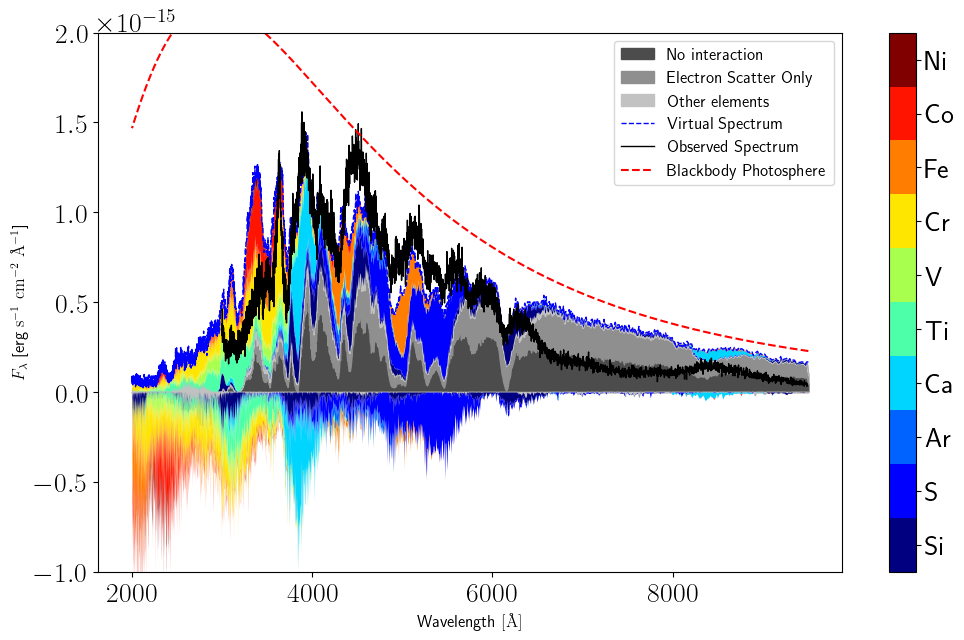

In [10]:
plotter = SDECPlotter.from_simulation(sim)
# 2D SEDONA simulation
syn_dat = np.loadtxt('./Shen+2021/d14e5_mu_0_spec.txt')
plotter.generate_plot_mpl(
    packet_wvl_range=[2000, 9500] * u.AA,
    observed_spectrum=(
        syn_dat[:, 0] * u.AA,
        syn_dat[:, 1] * u.erg / u.cm**2 / u.s / u.AA / 2.5,
    ),
    distance=114.48 * u.Mpc, nelements=10
)
ax = plt.gca()
ax.set_ylim([-1e-15, 2e-15])
plt.show()

[py.warnings         ][WARNING]  
	/Users/chang/miniconda3/envs/tardis/lib/python3.8/site-packages/astropy/units/quantity.py:1247: AstropyDeprecationWarning:

The truth value of a Quantity is ambiguous. In the future this will raise a ValueError.

 (warnings.py:109)
[tardis.visualization.tools.sdec_plot][INFO   ]  
	Ne is not in the absorbed packets; skipping (sdec_plot.py:1359)


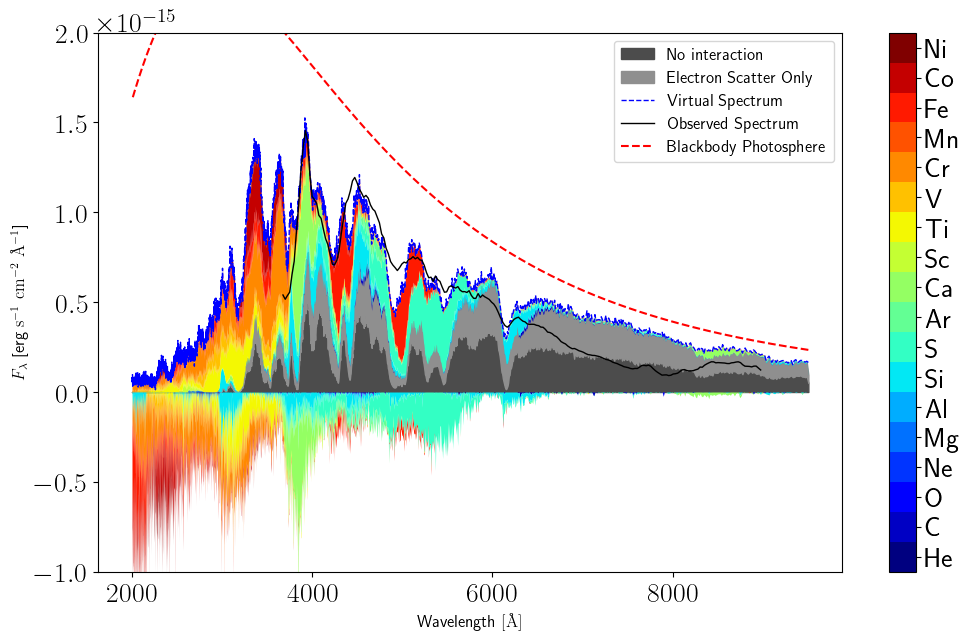

In [20]:
# observation
plotter.generate_plot_mpl(
    packet_wvl_range=[2000, 9500] * u.AA,
    # observed_spectrum=(
    #     syn_dat[:, 0] * u.AA,
    #     syn_dat[:, 1] * u.erg / u.cm**2 / u.s / u.AA / 2.5,
    # ),
    observed_spectrum=(
        joj2[:, 0] / (1 + z) * u.AA,
        joj2[:, 1] * (1 + z) * u.erg / u.cm**2 / u.s / u.AA / 2.5,
    ),
    distance=114.48 * u.Mpc
)
ax = plt.gca()
ax.set_ylim([-1e-15, 2e-15])
plt.show()

In [12]:
with open('./Shen+2021/d14e5_mu_0_spec.txt') as f:
    l = f.readline()
    time = float(l.split('=')[-1])
    l = f.readline()
    log_L = float(l.split('=')[-1])
write_CSVY('./d14e5_mu00', isotopes=iso_title, profile=profile, time=time, vmin=10000)
write_config(fname='tardis_+2.yml', log_L=log_L, time=time, csvy_model='d14e5_mu00')
sim0 = run_tardis("tardis_+2.yml",
                 virtual_packet_logging=True,
                 show_convergence_plots=True,
                 export_convergence_plots=True,
                 log_level="INFO")
plotter = SDECPlotter.from_simulation(sim0)

[tardis.model.base   ][WARNING]  
	Abundances have not been normalized to 1. - normalizing (base.py:892)
[tardis.plasma.standard_plasmas][INFO   ]  
	
	Reading Atomic Data from kurucz_cd23_chianti_H_He.h5 (standard_plasmas.py:95)
[tardis.io.atom_data.base][INFO   ]  
	Reading Atom Data with: UUID = 6f7b09e887a311e7a06b246e96350010 MD5  = 864f1753714343c41f99cb065710cace  (base.py:249)
[tardis.io.atom_data.base][INFO   ]  
	Non provided Atomic Data: synpp_refs, photoionization_data, yg_data, two_photon_data (base.py:253)
[py.warnings         ][WARNING]  
	/Users/chang/miniconda3/envs/tardis/lib/python3.8/site-packages/tardis/plasma/properties/radiative_properties.py:93: RuntimeWarning:

invalid value encountered in true_divide

 (warnings.py:109)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 1 of 40 (base.py:385)


TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:   ', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 4.080e+42 erg / s
	Luminosity absorbed  = 3.409e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.33e+03,9.77e+03,0.39,0.535
5,9.25e+03,9.25e+03,0.19,0.237
10,9.18e+03,8.56e+03,0.123,0.13
15,9.1e+03,7.82e+03,0.0869,0.109
20,9.03e+03,6.5e+03,0.0652,0.134
25,8.96e+03,6.32e+03,0.0509,0.111
30,8.89e+03,6.23e+03,0.0409,0.092
35,8.82e+03,6.16e+03,0.0336,0.0777


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9338.619 K
	Expected t_inner for next iteration = 9962.420 K
 (base.py:554)


    'data': [{'type': 'scatter', 'uid': '5f51dccd-3817-46c0-87dd-952ce0097cf9', …

[tardis.simulation.base][INFO   ]  
	
	Starting iteration 2 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.029e+42 erg / s
	Luminosity absorbed  = 4.397e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.77e+03,1.03e+04,0.535,0.571
5,9.25e+03,9.51e+03,0.237,0.274
10,8.56e+03,9.28e+03,0.13,0.137
15,7.82e+03,8.59e+03,0.109,0.113
20,6.5e+03,6.51e+03,0.134,0.164
25,6.32e+03,6.27e+03,0.111,0.139
30,6.23e+03,6.17e+03,0.092,0.115
35,6.16e+03,6.09e+03,0.0777,0.0979


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9962.420 K
	Expected t_inner for next iteration = 10462.862 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 3 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.951e+42 erg / s
	Luminosity absorbed  = 5.002e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.03e+04,1.09e+04,0.571,0.574
5,9.51e+03,9.8e+03,0.274,0.285
10,9.28e+03,9.53e+03,0.137,0.14
15,8.59e+03,8.88e+03,0.113,0.111
20,6.51e+03,6.93e+03,0.164,0.152
25,6.27e+03,6.63e+03,0.139,0.131
30,6.17e+03,6.53e+03,0.115,0.109
35,6.09e+03,6.45e+03,0.0979,0.092


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10462.862 K
	Expected t_inner for next iteration = 10861.507 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 4 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 6.945e+42 erg / s
	Luminosity absorbed  = 5.493e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.09e+04,1.13e+04,0.574,0.561
5,9.8e+03,1.02e+04,0.285,0.284
10,9.53e+03,9.74e+03,0.14,0.148
15,8.88e+03,9.01e+03,0.111,0.117
20,6.93e+03,7.11e+03,0.152,0.156
25,6.63e+03,6.87e+03,0.131,0.131
30,6.53e+03,6.77e+03,0.109,0.109
35,6.45e+03,6.68e+03,0.092,0.0923


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10861.507 K
	Expected t_inner for next iteration = 11163.914 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 5 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 7.709e+42 erg / s
	Luminosity absorbed  = 5.800e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.13e+04,1.17e+04,0.561,0.551
5,1.02e+04,1.06e+04,0.284,0.28
10,9.74e+03,1.02e+04,0.148,0.145
15,9.01e+03,9.41e+03,0.117,0.114
20,7.11e+03,7.31e+03,0.156,0.155
25,6.87e+03,7.07e+03,0.131,0.129
30,6.77e+03,6.96e+03,0.109,0.107
35,6.68e+03,6.87e+03,0.0923,0.0908


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 11163.914 K
	Expected t_inner for next iteration = 11402.166 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 6 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 8.227e+42 erg / s
	Luminosity absorbed  = 6.120e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.17e+04,1.2e+04,0.551,0.547
5,1.06e+04,1.08e+04,0.28,0.28
10,1.02e+04,1.03e+04,0.145,0.148
15,9.41e+03,9.37e+03,0.114,0.121
20,7.31e+03,7.37e+03,0.155,0.161
25,7.07e+03,7.13e+03,0.129,0.134
30,6.96e+03,7.02e+03,0.107,0.111
35,6.87e+03,6.93e+03,0.0908,0.0943


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 11402.166 K
	Expected t_inner for next iteration = 11601.236 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 7 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 8.699e+42 erg / s
	Luminosity absorbed  = 6.368e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.2e+04,1.23e+04,0.547,0.529
5,1.08e+04,1.12e+04,0.28,0.264
10,1.03e+04,1.05e+04,0.148,0.147
15,9.37e+03,9.52e+03,0.121,0.123
20,7.37e+03,7.46e+03,0.161,0.162
25,7.13e+03,7.21e+03,0.134,0.137
30,7.02e+03,7.09e+03,0.111,0.113
35,6.93e+03,7e+03,0.0943,0.096


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 11601.236 K
	Expected t_inner for next iteration = 11766.264 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 8 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 8.933e+42 erg / s
	Luminosity absorbed  = 6.670e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.23e+04,1.25e+04,0.529,0.53
5,1.12e+04,1.15e+04,0.264,0.258
10,1.05e+04,1.08e+04,0.147,0.144
15,9.52e+03,9.64e+03,0.123,0.121
20,7.46e+03,7.52e+03,0.162,0.161
25,7.21e+03,7.27e+03,0.137,0.135
30,7.09e+03,7.16e+03,0.113,0.112
35,7e+03,7.06e+03,0.096,0.0951


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 11766.264 K
	Expected t_inner for next iteration = 11915.955 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 9 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 9.164e+42 erg / s
	Luminosity absorbed  = 6.990e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.25e+04,1.28e+04,0.53,0.517
5,1.15e+04,1.17e+04,0.258,0.255
10,1.08e+04,1.08e+04,0.144,0.141
15,9.64e+03,9.71e+03,0.121,0.121
20,7.52e+03,7.61e+03,0.161,0.158
25,7.27e+03,7.35e+03,0.135,0.133
30,7.16e+03,7.23e+03,0.112,0.11
35,7.06e+03,7.14e+03,0.0951,0.0934


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 11915.955 K
	Expected t_inner for next iteration = 12050.505 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 10 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 9.418e+42 erg / s
	Luminosity absorbed  = 7.251e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.28e+04,1.3e+04,0.517,0.51
5,1.17e+04,1.19e+04,0.255,0.248
10,1.08e+04,1.09e+04,0.141,0.142
15,9.71e+03,9.62e+03,0.121,0.125
20,7.61e+03,7.61e+03,0.158,0.162
25,7.35e+03,7.33e+03,0.133,0.138
30,7.23e+03,7.22e+03,0.11,0.114
35,7.14e+03,7.13e+03,0.0934,0.0966


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 12050.505 K
	Expected t_inner for next iteration = 12168.337 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 11 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 9.565e+42 erg / s
	Luminosity absorbed  = 7.445e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.3e+04,1.32e+04,0.51,0.506
5,1.19e+04,1.23e+04,0.248,0.236
10,1.09e+04,1.12e+04,0.142,0.14
15,9.62e+03,9.9e+03,0.125,0.119
20,7.61e+03,7.64e+03,0.162,0.163
25,7.33e+03,7.37e+03,0.138,0.138
30,7.22e+03,7.25e+03,0.114,0.114
35,7.13e+03,7.16e+03,0.0966,0.097


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 12168.337 K
	Expected t_inner for next iteration = 12277.016 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 12 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 9.730e+42 erg / s
	Luminosity absorbed  = 7.663e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.32e+04,1.34e+04,0.506,0.494
5,1.23e+04,1.25e+04,0.236,0.226
10,1.12e+04,1.12e+04,0.14,0.14
15,9.9e+03,9.83e+03,0.119,0.123
20,7.64e+03,7.63e+03,0.163,0.165
25,7.37e+03,7.38e+03,0.138,0.138
30,7.25e+03,7.27e+03,0.114,0.114
35,7.16e+03,7.18e+03,0.097,0.0966


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 12277.016 K
	Expected t_inner for next iteration = 12375.273 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 13 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 9.806e+42 erg / s
	Luminosity absorbed  = 7.982e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.34e+04,1.35e+04,0.494,0.504
5,1.25e+04,1.27e+04,0.226,0.225
10,1.12e+04,1.13e+04,0.14,0.139
15,9.83e+03,9.93e+03,0.123,0.121
20,7.63e+03,7.74e+03,0.165,0.16
25,7.38e+03,7.41e+03,0.138,0.138
30,7.27e+03,7.29e+03,0.114,0.115
35,7.18e+03,7.2e+03,0.0966,0.0974


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 12375.273 K
	Expected t_inner for next iteration = 12469.182 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 14 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.001e+43 erg / s
	Luminosity absorbed  = 8.192e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.35e+04,1.37e+04,0.504,0.494
5,1.27e+04,1.28e+04,0.225,0.228
10,1.13e+04,1.15e+04,0.139,0.135
15,9.93e+03,1.01e+04,0.121,0.119
20,7.74e+03,7.72e+03,0.16,0.164
25,7.41e+03,7.44e+03,0.138,0.138
30,7.29e+03,7.32e+03,0.115,0.115
35,7.2e+03,7.23e+03,0.0974,0.0974


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 12469.182 K
	Expected t_inner for next iteration = 12549.832 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 15 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.011e+43 erg / s
	Luminosity absorbed  = 8.357e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.37e+04,1.38e+04,0.494,0.501
5,1.28e+04,1.3e+04,0.228,0.222
10,1.15e+04,1.18e+04,0.135,0.13
15,1.01e+04,1.02e+04,0.119,0.115
20,7.72e+03,7.82e+03,0.164,0.158
25,7.44e+03,7.53e+03,0.138,0.134
30,7.32e+03,7.41e+03,0.115,0.111
35,7.23e+03,7.32e+03,0.0974,0.094


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 12549.832 K
	Expected t_inner for next iteration = 12624.808 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 16 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.008e+43 erg / s
	Luminosity absorbed  = 8.593e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.38e+04,1.39e+04,0.501,0.497
5,1.3e+04,1.31e+04,0.222,0.217
10,1.18e+04,1.21e+04,0.13,0.122
15,1.02e+04,1.02e+04,0.115,0.114
20,7.82e+03,7.85e+03,0.158,0.156
25,7.53e+03,7.57e+03,0.134,0.131
30,7.41e+03,7.44e+03,0.111,0.109
35,7.32e+03,7.35e+03,0.094,0.0922


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 12624.808 K
	Expected t_inner for next iteration = 12701.905 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 17 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.015e+43 erg / s
	Luminosity absorbed  = 8.720e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.39e+04,1.4e+04,0.497,0.496
5,1.31e+04,1.34e+04,0.217,0.213
10,1.21e+04,1.22e+04,0.122,0.122
15,1.02e+04,1.04e+04,0.114,0.111
20,7.85e+03,7.91e+03,0.156,0.155
25,7.57e+03,7.59e+03,0.131,0.132
30,7.44e+03,7.47e+03,0.109,0.11
35,7.35e+03,7.37e+03,0.0922,0.0929


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 12701.905 K
	Expected t_inner for next iteration = 12774.785 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 18 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.033e+43 erg / s
	Luminosity absorbed  = 8.828e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 1/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.4e+04,1.41e+04,0.496,0.496
5,1.34e+04,1.37e+04,0.213,0.208
10,1.22e+04,1.24e+04,0.122,0.117
15,1.04e+04,1.05e+04,0.111,0.111
20,7.91e+03,7.96e+03,0.155,0.155
25,7.59e+03,7.66e+03,0.132,0.131
30,7.47e+03,7.53e+03,0.11,0.109
35,7.37e+03,7.43e+03,0.0929,0.092


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 12774.785 K
	Expected t_inner for next iteration = 12836.601 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 19 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.051e+43 erg / s
	Luminosity absorbed  = 8.777e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 2/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.41e+04,1.42e+04,0.496,0.498
5,1.37e+04,1.4e+04,0.208,0.205
10,1.24e+04,1.29e+04,0.117,0.111
15,1.05e+04,1.08e+04,0.111,0.106
20,7.96e+03,8e+03,0.155,0.155
25,7.66e+03,7.7e+03,0.131,0.131
30,7.53e+03,7.58e+03,0.109,0.108
35,7.43e+03,7.48e+03,0.092,0.0915


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 12836.601 K
	Expected t_inner for next iteration = 12886.862 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 20 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.063e+43 erg / s
	Luminosity absorbed  = 8.912e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 3/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.42e+04,1.42e+04,0.498,0.499
5,1.4e+04,1.41e+04,0.205,0.206
10,1.29e+04,1.32e+04,0.111,0.107
15,1.08e+04,1.1e+04,0.106,0.103
20,8e+03,8.14e+03,0.155,0.148
25,7.7e+03,7.83e+03,0.131,0.125
30,7.58e+03,7.7e+03,0.108,0.104
35,7.48e+03,7.6e+03,0.0915,0.088


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 12886.862 K
	Expected t_inner for next iteration = 12929.884 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 21 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.064e+43 erg / s
	Luminosity absorbed  = 8.999e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.42e+04,1.43e+04,0.499,0.493
5,1.41e+04,1.41e+04,0.206,0.197
10,1.32e+04,1.32e+04,0.107,0.104
15,1.1e+04,1.13e+04,0.103,0.0945
20,8.14e+03,8.23e+03,0.148,0.143
25,7.83e+03,7.92e+03,0.125,0.12
30,7.7e+03,7.79e+03,0.104,0.0992
35,7.6e+03,7.69e+03,0.088,0.0839


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 12929.884 K
	Expected t_inner for next iteration = 12972.526 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 22 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.077e+43 erg / s
	Luminosity absorbed  = 8.836e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 1/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.43e+04,1.44e+04,0.493,0.487
5,1.41e+04,1.41e+04,0.197,0.203
10,1.32e+04,1.34e+04,0.104,0.101
15,1.13e+04,1.15e+04,0.0945,0.0931
20,8.23e+03,8.39e+03,0.143,0.136
25,7.92e+03,8.02e+03,0.12,0.117
30,7.79e+03,7.89e+03,0.0992,0.0971
35,7.69e+03,7.78e+03,0.0839,0.0822


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 12972.526 K
	Expected t_inner for next iteration = 13007.255 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 23 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.061e+43 erg / s
	Luminosity absorbed  = 9.150e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.44e+04,1.43e+04,0.487,0.503
5,1.41e+04,1.41e+04,0.203,0.203
10,1.34e+04,1.37e+04,0.101,0.0952
15,1.15e+04,1.18e+04,0.0931,0.0857
20,8.39e+03,8.53e+03,0.136,0.129
25,8.02e+03,8.1e+03,0.117,0.113
30,7.89e+03,7.96e+03,0.0971,0.0936
35,7.78e+03,7.86e+03,0.0822,0.0792


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 13007.255 K
	Expected t_inner for next iteration = 13051.955 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 24 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.090e+43 erg / s
	Luminosity absorbed  = 9.228e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 1/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.43e+04,1.44e+04,0.503,0.505
5,1.41e+04,1.4e+04,0.203,0.205
10,1.37e+04,1.38e+04,0.0952,0.0928
15,1.18e+04,1.19e+04,0.0857,0.0856
20,8.53e+03,8.53e+03,0.129,0.133
25,8.1e+03,8.11e+03,0.113,0.115
30,7.96e+03,7.97e+03,0.0936,0.0955
35,7.86e+03,7.87e+03,0.0792,0.0808


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 13051.955 K
	Expected t_inner for next iteration = 13078.567 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 25 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.072e+43 erg / s
	Luminosity absorbed  = 9.165e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 2/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.44e+04,1.44e+04,0.505,0.493
5,1.4e+04,1.39e+04,0.205,0.206
10,1.38e+04,1.35e+04,0.0928,0.0956
15,1.19e+04,1.19e+04,0.0856,0.0841
20,8.53e+03,8.5e+03,0.133,0.134
25,8.11e+03,8.09e+03,0.115,0.116
30,7.97e+03,7.95e+03,0.0955,0.096
35,7.87e+03,7.84e+03,0.0808,0.0813


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 13078.567 K
	Expected t_inner for next iteration = 13116.588 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 26 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.112e+43 erg / s
	Luminosity absorbed  = 9.506e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.44e+04,1.44e+04,0.493,0.499
5,1.39e+04,1.39e+04,0.206,0.214
10,1.35e+04,1.33e+04,0.0956,0.102
15,1.19e+04,1.17e+04,0.0841,0.0896
20,8.5e+03,8.4e+03,0.134,0.141
25,8.09e+03,8.02e+03,0.116,0.121
30,7.95e+03,7.89e+03,0.096,0.101
35,7.84e+03,7.78e+03,0.0813,0.0852


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 13116.588 K
	Expected t_inner for next iteration = 13130.304 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 27 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.110e+43 erg / s
	Luminosity absorbed  = 9.288e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 1/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.44e+04,1.45e+04,0.499,0.493
5,1.39e+04,1.41e+04,0.214,0.21
10,1.33e+04,1.34e+04,0.102,0.104
15,1.17e+04,1.16e+04,0.0896,0.0907
20,8.4e+03,8.36e+03,0.141,0.144
25,8.02e+03,7.99e+03,0.121,0.123
30,7.89e+03,7.86e+03,0.101,0.102
35,7.78e+03,7.76e+03,0.0852,0.0865


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 13130.304 K
	Expected t_inner for next iteration = 13145.229 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 28 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.138e+43 erg / s
	Luminosity absorbed  = 9.302e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 2/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.45e+04,1.44e+04,0.493,0.507
5,1.41e+04,1.41e+04,0.21,0.207
10,1.34e+04,1.33e+04,0.104,0.105
15,1.16e+04,1.16e+04,0.0907,0.0924
20,8.36e+03,8.38e+03,0.144,0.144
25,7.99e+03,8.04e+03,0.123,0.122
30,7.86e+03,7.91e+03,0.102,0.101
35,7.76e+03,7.81e+03,0.0865,0.0858


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 13145.229 K
	Expected t_inner for next iteration = 13143.441 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 29 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.121e+43 erg / s
	Luminosity absorbed  = 9.254e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 3/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.44e+04,1.44e+04,0.507,0.503
5,1.41e+04,1.4e+04,0.207,0.211
10,1.33e+04,1.33e+04,0.105,0.103
15,1.16e+04,1.17e+04,0.0924,0.0911
20,8.38e+03,8.38e+03,0.144,0.143
25,8.04e+03,8.05e+03,0.122,0.121
30,7.91e+03,7.92e+03,0.101,0.1
35,7.81e+03,7.82e+03,0.0858,0.0846


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 13143.441 K
	Expected t_inner for next iteration = 13151.798 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 30 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.119e+43 erg / s
	Luminosity absorbed  = 9.354e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 4/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.44e+04,1.45e+04,0.503,0.498
5,1.4e+04,1.4e+04,0.211,0.21
10,1.33e+04,1.34e+04,0.103,0.102
15,1.17e+04,1.18e+04,0.0911,0.0878
20,8.38e+03,8.46e+03,0.143,0.138
25,8.05e+03,8.07e+03,0.121,0.119
30,7.92e+03,7.93e+03,0.1,0.0989
35,7.82e+03,7.83e+03,0.0846,0.0837


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 13151.798 K
	Expected t_inner for next iteration = 13160.939 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 31 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.130e+43 erg / s
	Luminosity absorbed  = 9.207e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 5/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.45e+04,1.44e+04,0.498,0.503
5,1.4e+04,1.41e+04,0.21,0.213
10,1.34e+04,1.33e+04,0.102,0.106
15,1.18e+04,1.17e+04,0.0878,0.0912
20,8.46e+03,8.39e+03,0.138,0.144
25,8.07e+03,8.05e+03,0.119,0.122
30,7.93e+03,7.92e+03,0.0989,0.101
35,7.83e+03,7.81e+03,0.0837,0.0856


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 13160.939 K
	Expected t_inner for next iteration = 13163.933 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 32 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.136e+43 erg / s
	Luminosity absorbed  = 9.311e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 6/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.44e+04,1.45e+04,0.503,0.5
5,1.41e+04,1.42e+04,0.213,0.21
10,1.33e+04,1.35e+04,0.106,0.104
15,1.17e+04,1.18e+04,0.0912,0.0893
20,8.39e+03,8.4e+03,0.144,0.143
25,8.05e+03,8.06e+03,0.122,0.121
30,7.92e+03,7.93e+03,0.101,0.1
35,7.81e+03,7.83e+03,0.0856,0.0846


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 13163.933 K
	Expected t_inner for next iteration = 13163.106 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 33 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.129e+43 erg / s
	Luminosity absorbed  = 9.342e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 7/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.45e+04,1.45e+04,0.5,0.497
5,1.42e+04,1.42e+04,0.21,0.206
10,1.35e+04,1.36e+04,0.104,0.0998
15,1.18e+04,1.18e+04,0.0893,0.0888
20,8.4e+03,8.42e+03,0.143,0.141
25,8.06e+03,8.08e+03,0.121,0.12
30,7.93e+03,7.94e+03,0.1,0.0992
35,7.83e+03,7.84e+03,0.0846,0.0839


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 13163.106 K
	Expected t_inner for next iteration = 13166.650 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 34 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.119e+43 erg / s
	Luminosity absorbed  = 9.268e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 8/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.45e+04,1.45e+04,0.497,0.498
5,1.42e+04,1.43e+04,0.206,0.2
10,1.36e+04,1.36e+04,0.0998,0.0981
15,1.18e+04,1.18e+04,0.0888,0.0879
20,8.42e+03,8.52e+03,0.141,0.136
25,8.08e+03,8.14e+03,0.12,0.117
30,7.94e+03,8.01e+03,0.0992,0.0967
35,7.84e+03,7.9e+03,0.0839,0.0819


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 13166.650 K
	Expected t_inner for next iteration = 13176.013 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 35 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.109e+43 erg / s
	Luminosity absorbed  = 9.438e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 9/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.45e+04,1.45e+04,0.498,0.508
5,1.43e+04,1.42e+04,0.2,0.204
10,1.36e+04,1.38e+04,0.0981,0.0955
15,1.18e+04,1.2e+04,0.0879,0.0848
20,8.52e+03,8.45e+03,0.136,0.139
25,8.14e+03,8.11e+03,0.117,0.117
30,8.01e+03,7.98e+03,0.0967,0.097
35,7.9e+03,7.88e+03,0.0819,0.082


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 13176.013 K
	Expected t_inner for next iteration = 13191.650 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 36 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.135e+43 erg / s
	Luminosity absorbed  = 9.536e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 10/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.45e+04,1.44e+04,0.508,0.513
5,1.42e+04,1.42e+04,0.204,0.206
10,1.38e+04,1.38e+04,0.0955,0.0948
15,1.2e+04,1.2e+04,0.0848,0.0872
20,8.45e+03,8.54e+03,0.139,0.138
25,8.11e+03,8.17e+03,0.117,0.118
30,7.98e+03,8.01e+03,0.097,0.0986
35,7.88e+03,7.9e+03,0.082,0.0834


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 13191.650 K
	Expected t_inner for next iteration = 13191.639 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 37 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.119e+43 erg / s
	Luminosity absorbed  = 9.489e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 11/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.44e+04,1.45e+04,0.513,0.505
5,1.42e+04,1.42e+04,0.206,0.206
10,1.38e+04,1.37e+04,0.0948,0.0956
15,1.2e+04,1.19e+04,0.0872,0.0868
20,8.54e+03,8.59e+03,0.138,0.133
25,8.17e+03,8.17e+03,0.118,0.115
30,8.01e+03,8.04e+03,0.0986,0.0957
35,7.9e+03,7.93e+03,0.0834,0.0809


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 13191.639 K
	Expected t_inner for next iteration = 13201.178 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 38 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.134e+43 erg / s
	Luminosity absorbed  = 9.417e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 12/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.45e+04,1.45e+04,0.505,0.504
5,1.42e+04,1.42e+04,0.206,0.205
10,1.37e+04,1.37e+04,0.0956,0.0961
15,1.19e+04,1.21e+04,0.0868,0.0856
20,8.59e+03,8.54e+03,0.133,0.136
25,8.17e+03,8.16e+03,0.115,0.116
30,8.04e+03,8.02e+03,0.0957,0.0968
35,7.93e+03,7.91e+03,0.0809,0.0819


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 13201.178 K
	Expected t_inner for next iteration = 13201.949 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 39 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.128e+43 erg / s
	Luminosity absorbed  = 9.593e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 13/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.45e+04,1.45e+04,0.504,0.505
5,1.42e+04,1.42e+04,0.205,0.203
10,1.37e+04,1.36e+04,0.0961,0.096
15,1.21e+04,1.19e+04,0.0856,0.0844
20,8.54e+03,8.57e+03,0.136,0.134
25,8.16e+03,8.18e+03,0.116,0.115
30,8.02e+03,8.05e+03,0.0968,0.0949
35,7.91e+03,7.93e+03,0.0819,0.0807


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 13201.949 K
	Expected t_inner for next iteration = 13205.822 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 40 of 40 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.129e+43 erg / s
	Luminosity absorbed  = 9.516e+42 erg / s
	Luminosity requested = 1.135e+43 erg / s
 (base.py:559)


[tardis.simulation.base][INFO   ]  
	
	Simulation finished in 40 iterations 
	Simulation took 490.38 s
 (base.py:480)


[py.warnings         ][WARNING]  
	/Users/chang/miniconda3/envs/tardis/lib/python3.8/site-packages/astropy/units/quantity.py:1247: AstropyDeprecationWarning:

The truth value of a Quantity is ambiguous. In the future this will raise a ValueError.

 (warnings.py:109)


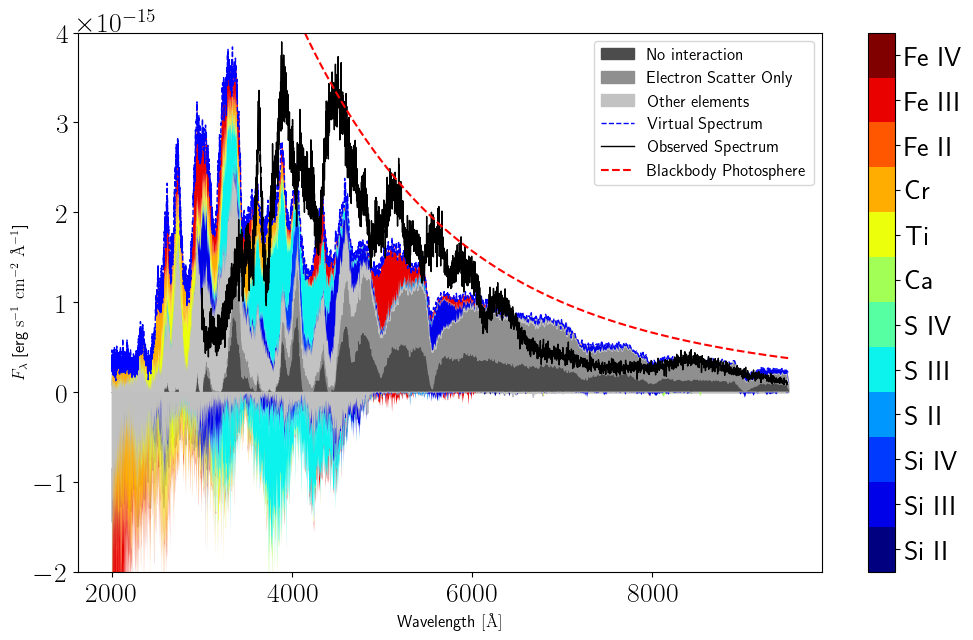

In [17]:
# 2D SEDONA simulation
syn_dat = np.loadtxt('./Shen+2021/d14e5_mu_0_spec.txt')
plotter.generate_plot_mpl(
    packet_wvl_range=[2000, 9500] * u.AA,
    observed_spectrum=(
        syn_dat[:, 0] * u.AA,
        syn_dat[:, 1] * u.erg / u.cm**2 / u.s / u.AA,
    ),
    distance=114.48 * u.Mpc, species_list = ['Si II-IV', 'S II-IV', 'Fe II-IV', 'Ca', 'Ti', 'Cr']
)
ax = plt.gca()
ax.set_ylim([-2e-15, 4e-15])
plt.show()